<h2> Importing labels for both dataset A (Apple) and dataset B (hospital)

In [1]:
import os
import pandas as pd
import numpy as np
import pylab
import wave
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [2]:
filepath_set_a = os.path.join('..', 'data', 'heartbeat-sounds', 'set_a.csv')

In [3]:
filepath_set_b = os.path.join('..', 'data', 'heartbeat-sounds', 'set_b.csv')

In [4]:
set_a = pd.read_csv(filepath_set_a)

In [5]:
set_b = pd.read_csv(filepath_set_b)

<h2> EDA

Let's have a first look at our labels.

In [6]:
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [7]:
set_b.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [8]:
set_a['label'].value_counts()

artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

In [9]:
set_b['label'].value_counts()

normal        320
murmur         95
extrastole     46
Name: label, dtype: int64

In [10]:
set_a.isna().sum()

dataset       0
fname         0
label        52
sublabel    176
dtype: int64

In [11]:
set_a.shape

(176, 4)

In [12]:
set_b.isna().sum()

dataset       0
fname         0
label       195
sublabel    507
dtype: int64

<h4> As we can see, lots of labels and sublabels are NAN values. We can drop sublabels. 
<h4> Regarding empty labels, as we are in a medical context, I decided to drop them too: determining their nature would require the consult of a specialist that I unfortunately cannot afford.

In [13]:
set_a = set_a.drop(columns = 'sublabel')

In [14]:
set_b = set_b.drop(columns = 'sublabel')

Before dropping all NAN values from the labels, we will save their names. This way, it will be easier for us to remove corresponding sound files from our dataframe. 

In [15]:
NAN_labels_a = set_a.loc[set_a['label'].isna() == True]
NAN_labels_a = NAN_labels_a.iloc[:,1]
NAN_labels_a

124    set_a/__201012172010.wav
125    set_a/__201101051105.wav
126    set_a/__201101061552.wav
127    set_a/__201101091156.wav
128    set_a/__201101110659.wav
129    set_a/__201101152256.wav
130    set_a/__201101220549.wav
131    set_a/__201101241434.wav
132    set_a/__201102081033.wav
133    set_a/__201102081045.wav
134    set_a/__201102200848.wav
135    set_a/__201103011036.wav
136    set_a/__201103140236.wav
137    set_a/__201103170122.wav
138    set_a/__201103200518.wav
139    set_a/__201103201314.wav
140    set_a/__201103232251.wav
141    set_a/__201103241336.wav
142    set_a/__201104012144.wav
143      set_a/__2011040239.wav
144    set_a/__201105011546.wav
145     set_a/__20110501548.wav
146    set_a/__201105031730.wav
147    set_a/__201106010807.wav
148    set_a/__201106030607.wav
149    set_a/__201106031556.wav
150    set_a/__201106040930.wav
151    set_a/__201106061104.wav
152    set_a/__201106061215.wav
153    set_a/__201106100606.wav
154    set_a/__201106111419.wav
155    s

In [16]:
NAN_labels_b = set_b.loc[set_b['label'].isna() == True]
NAN_labels_b = NAN_labels_b.iloc[:,1]
NAN_labels_b

312    set_b/Bunlabelledtest_101_1305030823364_A.wav
313    set_b/Bunlabelledtest_101_1305030823364_D.wav
314    set_b/Bunlabelledtest_101_1305030823364_F.wav
315    set_b/Bunlabelledtest_103_1305031931979_A.wav
316    set_b/Bunlabelledtest_103_1305031931979_C.wav
                           ...                      
502    set_b/Bunlabelledtest_296_1311682952647_A.wav
503    set_b/Bunlabelledtest_296_1311682952647_B.wav
504    set_b/Bunlabelledtest_300_1311772096120_B.wav
505    set_b/Bunlabelledtest_300_1311772096120_C.wav
506    set_b/Bunlabelledtest_300_1311772096120_D.wav
Name: fname, Length: 195, dtype: object

In [17]:
# now we can drop them too.

In [18]:
set_a = set_a.dropna(subset=['label'])

In [19]:
set_b = set_b.dropna(subset=['label'])

In [20]:
set_a.shape

(124, 3)

In [21]:
set_a.isna().sum()

dataset    0
fname      0
label      0
dtype: int64

In [22]:
set_b.shape

(461, 3)

In [23]:
set_b.isna().sum()

dataset    0
fname      0
label      0
dtype: int64

<h2> Dowloading all WAV sounds files

<h3> Starting with sounds from the Apple app (set a)

In [24]:
filepath_sounds_a = os.path.join('..', 'data', 'heartbeat-sounds', 'set_a')

In [25]:
def getListOfFiles(dirPath):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirPath)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirPath, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [26]:
all_sounds_a = getListOfFiles(filepath_sounds_a)

In [27]:
all_sounds_a

['../data/heartbeat-sounds/set_a/artifact__201106161019.wav',
 '../data/heartbeat-sounds/set_a/Aunlabelledtest__201104012144.wav',
 '../data/heartbeat-sounds/set_a/Aunlabelledtest__201106111419.wav',
 '../data/heartbeat-sounds/set_a/normal__201103170121.wav',
 '../data/heartbeat-sounds/set_a/extrahls__201102241217.wav',
 '../data/heartbeat-sounds/set_a/normal__201106210943.wav',
 '../data/heartbeat-sounds/set_a/normal__201104141251.wav',
 '../data/heartbeat-sounds/set_a/Aunlabelledtest__201108222234.wav',
 '../data/heartbeat-sounds/set_a/Aunlabelledtest__201108011117.wav',
 '../data/heartbeat-sounds/set_a/Aunlabelledtest__201103170122.wav',
 '../data/heartbeat-sounds/set_a/normal__201105151450.wav',
 '../data/heartbeat-sounds/set_a/Aunlabelledtest__201108222225.wav',
 '../data/heartbeat-sounds/set_a/Aunlabelledtest__201106212102.wav',
 '../data/heartbeat-sounds/set_a/artifact__201106211430.wav',
 '../data/heartbeat-sounds/set_a/extrahls__201104270458.wav',
 '../data/heartbeat-sounds/se

In [28]:
filepath_sounds_b = os.path.join('..', 'data', 'heartbeat-sounds', 'set_b')

In [29]:
all_sounds_b = getListOfFiles(filepath_sounds_b)

<h3> Dropping files with no corresponding labels

In [30]:
# Lets reload our lists of indexes for NAN labels and save them as numpy arrays.

NAN_labels_a = np.array(NAN_labels_a)

NAN_labels_b = np.array(NAN_labels_b)

In [31]:
NAN_labels_a = ['../../data/heartbeat-sounds/'+NAN_labels_a[e] for e in range(len(NAN_labels_a))]

In [32]:
all_sounds_a_modified = all_sounds_a
all_sounds_a_modified = [s.replace('normal', '') for s in all_sounds_a_modified]
all_sounds_a_modified = [s.replace('Aunlabelledtest', '') for s in all_sounds_a_modified]
all_sounds_a_modified = [s.replace('extrahls', '') for s in all_sounds_a_modified]
all_sounds_a_modified = [s.replace('artifact', '') for s in all_sounds_a_modified]
all_sounds_a_modified = [s.replace('murmur', '') for s in all_sounds_a_modified]

In [33]:
sounds_a_to_be_dropped = []
for i in range(len(all_sounds_a_modified)):
    if all_sounds_a_modified[i] in NAN_labels_a:
        sounds_a_to_be_dropped.append(i)

In [34]:
all_sounds_a_cleaned = []
for i in range(len(all_sounds_a)):
    if i not in sounds_a_to_be_dropped:
        all_sounds_a_cleaned.append(all_sounds_a[i])

In [35]:
len(all_sounds_a_cleaned)

176

In [36]:
all_sounds_b

['../data/heartbeat-sounds/set_b/extrastole__194_1308139824187_B.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_157_1306937583792_A.wav',
 '../data/heartbeat-sounds/set_b/Bunlabelledtest__195_1308140095331_D.wav',
 '../data/heartbeat-sounds/set_b/Bunlabelledtest__155_1306935902813_D.wav',
 '../data/heartbeat-sounds/set_b/normal__181_1308052613891_D.wav',
 '../data/heartbeat-sounds/set_b/Bunlabelledtest__157_1306937583792_C.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_284_1311168471850_B.wav',
 '../data/heartbeat-sounds/set_b/murmur__197_1308141235553_C.wav',
 '../data/heartbeat-sounds/set_b/Bunlabelledtest__108_1305654420093_C.wav',
 '../data/heartbeat-sounds/set_b/Bunlabelledtest__134_1306428161797_B.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_144_1306522408528_C.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_271_1309369876160_D.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_129_1306344506305_C.wav',
 '../data/heartbeat-sound

Fortunately, for set_b all files with no labels are only the one containing the sentence 'Bunlabelledtest' 
(for unlabelled test in set_b).

Therefore, we will drop all of them from our soundfiles package. 

In [37]:
len(all_sounds_b)

656

In [38]:
for i in all_sounds_b:
    if 'Bunlabelledtest' in i:
        all_sounds_b.remove(i)

In [39]:
len(all_sounds_b)

502

In [40]:
all_sounds_b

['../data/heartbeat-sounds/set_b/extrastole__194_1308139824187_B.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_157_1306937583792_A.wav',
 '../data/heartbeat-sounds/set_b/Bunlabelledtest__155_1306935902813_D.wav',
 '../data/heartbeat-sounds/set_b/normal__181_1308052613891_D.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_284_1311168471850_B.wav',
 '../data/heartbeat-sounds/set_b/murmur__197_1308141235553_C.wav',
 '../data/heartbeat-sounds/set_b/Bunlabelledtest__134_1306428161797_B.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_144_1306522408528_C.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_271_1309369876160_D.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_129_1306344506305_C.wav',
 '../data/heartbeat-sounds/set_b/normal__177_1307989650056_A1.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_285_1311169246969_C.wav',
 '../data/heartbeat-sounds/set_b/normal__218_1308246311449_C.wav',
 '../data/heartbeat-sounds/set_b/normal_

In [41]:
for i in all_sounds_b:
    if 'Bunlabelledtest' in i:
        all_sounds_b.remove(i)

In [42]:
len(all_sounds_b)

463

In [43]:
for i in all_sounds_b:
    if 'Bunlabelledtest' in i:
        all_sounds_b.remove(i)

In [44]:
len(all_sounds_b)

461

In [45]:
all_sounds_b

['../data/heartbeat-sounds/set_b/extrastole__194_1308139824187_B.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_157_1306937583792_A.wav',
 '../data/heartbeat-sounds/set_b/normal__181_1308052613891_D.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_284_1311168471850_B.wav',
 '../data/heartbeat-sounds/set_b/murmur__197_1308141235553_C.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_144_1306522408528_C.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_271_1309369876160_D.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_129_1306344506305_C.wav',
 '../data/heartbeat-sounds/set_b/normal__177_1307989650056_A1.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_285_1311169246969_C.wav',
 '../data/heartbeat-sounds/set_b/normal__218_1308246311449_C.wav',
 '../data/heartbeat-sounds/set_b/normal_noisynormal_181_1308052613891_A.wav',
 '../data/heartbeat-sounds/set_b/normal__209_1308162216750_A.wav',
 '../data/heartbeat-sounds/set_b/normal__125_13

<h2> Transforming soundfiles into numpy arrays using Librosa

Python package for music and audio processing, Librosa, has been created by Brian McFee and allow us to transform audio in a numpy array.
In that aim, we will use the popular Mel-frequency cepstral coefficients. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

In [46]:
# First, we build a function to transform all sounds in our main folder:

In [47]:
sounds_a = []
for file in all_sounds_a_cleaned:
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    sounds_a.append(audio)

In [48]:
sounds_b = []
for file in all_sounds_b:
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    sounds_b.append(audio)

In [49]:
sounds_a = np.array(sounds_a)
sounds_b = np.array(sounds_b)
all_sounds = np.concatenate((sounds_a, sounds_b))

In [50]:
max_pad_len = 173

In [51]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=4) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [52]:
def extract_sounds(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

<h3> Apple dataset

In [53]:
# Then, we apply the function to our filepath:

In [54]:
features = []


for file in all_sounds_a_cleaned:
    
    #class_label = i["class_name"]
    data = extract_features(file)
    
    features.append(data)

features = np.array(features)
featuresdf = pd.DataFrame(features)

In [55]:
features.shape

(176, 40)

In [56]:
apple_sounds = []
for file in all_sounds_a_cleaned:
    
    #class_label = i["class_name"]
    data = extract_sounds(file)
    
    apple_sounds.append(data)

Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/artifact__201106161019.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/Aunlabelledtest__201104012144.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/Aunlabelledtest__201106111419.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/normal__201103170121.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/extrahls__201102241217.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/normal__201106210943.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/normal__201104141251.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/Aunlabelledtest__201108222234.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/Aunlabelledtest__201108011117.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/Aunlabelledtest__201103170122.wav
E

Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/artifact__201106131834.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/artifact__201106171003.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/normal__201102081321.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/normal__201106221450.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/artifact__201106161016.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/artifact__201106110909.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/artifact__201106101955.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/murmur__201103291548.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/murmur__201108222251.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_a/artifact__201106070537.wav
Error encountered while parsing file: 

In [57]:
apple_sounds = np.asarray(apple_sounds)

In [58]:
apple_sounds.shape

(176,)

<h3> Clinic dataset

In [59]:
clinic_features = []


for file in all_sounds_b:
    
    #class_label = i["class_name"]
    data = extract_features(file)
    
    clinic_features.append(data)


features_clinic = pd.DataFrame(clinic_features)

In [60]:
clinic_sounds = []
for file in all_sounds_b:
    
    #class_label = i["class_name"]
    data = extract_sounds(file)
    
    clinic_sounds.append(data)

Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/extrastole__194_1308139824187_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_157_1306937583792_A.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_284_1311168471850_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/murmur__197_1308141235553_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_144_1306522408528_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_271_1309369876160_D.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_129_1306344506305_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_285_1311169246969_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_181_1308052613891_A.wav
E

Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/murmur__239_1309195730333_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__172_1307971284351_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__128_1306344005749_D1.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/murmur_noisymurmur_240_1309201366049_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/extrastole__213_1308245263936_D.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__167_1307111318050_A.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/extrastole__184_1308073010307_A.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__154_1306935608852_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/extrastole__198_1308141739338_B.wav
Error encountered while parsing file:  ../data/heartbeat-s

Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_133_1306759619127_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/murmur__160_1307100683334_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/murmur_noisymurmur_185_1308073325396_D.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__207_1308159792607_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__175_1307987962616_D.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__180_1307990956284_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__178_1307989887769_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_264_1309356143724_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__150_1306776340746_B.wav
Error encountered while parsing file:  ../data/he

Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_207_1308159792607_D.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_143_1306763822290_A.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__217_1308246111629_C.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__177_1307989650056_B.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/murmur__112_1306243000964_A.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_141_1306520154450_A1.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal__106_1306776721273_D2.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_113_1306244002866_A.wav
Error encountered while parsing file:  ../data/heartbeat-sounds/set_b/normal_noisynormal_216_1308245839516_D.wav
Error encountered while p

In [61]:
clinic_sounds = np.array(clinic_sounds)

In [62]:
clinic_sounds.shape

(461,)

<h3> Plot Apple sounds for a first look

In [63]:
all_features = np.concatenate((features,clinic_features))

In [64]:
i = np.random.randint(len(all_features))
i

283

In [65]:
import librosa.display

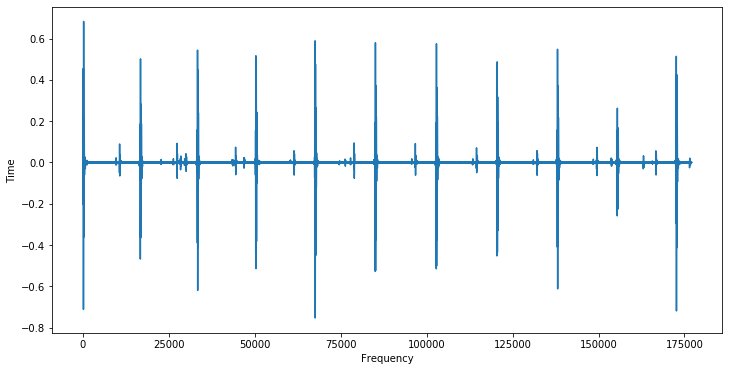

In [66]:
plt.show()
plt.figure(figsize=(12,6))
plt.ylabel('Time')
plt.xlabel('Frequency')
plt.plot(sounds_a[3])

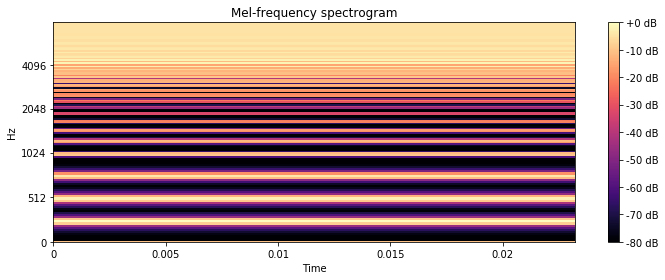

In [67]:
plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(all_features[i])
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel',
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

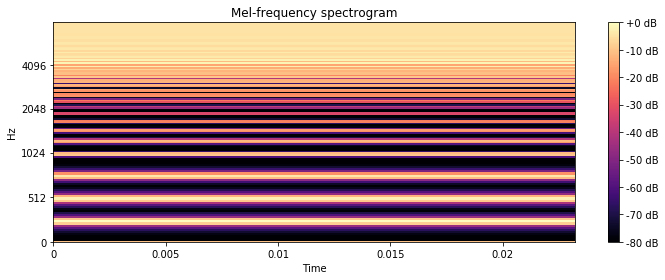

In [68]:
S2 = librosa.feature.melspectrogram(all_features[i])
plt.figure(figsize=(10, 4))
S2_dB = librosa.power_to_db(S2, ref=np.max)
librosa.display.specshow(S2_dB, x_axis='time',
                         y_axis='mel',
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

<h2> Machine Learning

<h3> Supervised

In [69]:
df_all_features = pd.concat([featuresdf, features_clinic])

In [70]:
X = df_all_features

In [71]:
y_a = set_a['label']

In [72]:
y_b = set_b['label']

In [73]:
y = pd.concat([y_a, y_b])

In [74]:
y.value_counts()

normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: label, dtype: int64

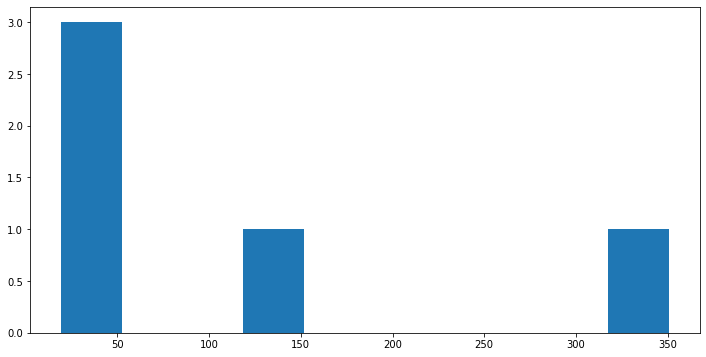

In [75]:
plt.figure(figsize=(12,6))
plt.hist(y.value_counts())
plt.show()

<h3> Logistic Regression

In [76]:
# Let's create a binary version of y (0 == normal, 1 == anormal) to perform Logistic regression

In [77]:
def get_class(X):
    if X == 'normal':
        return 0
    else:
        return 1

In [78]:
y_binary = y.apply(get_class)

In [79]:
y_binary.value_counts()

0    351
1    234
Name: label, dtype: int64

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
len(X)

637

In [82]:
len(y)

585

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size = 0.2, random_state = 0)

ValueError: Found input variables with inconsistent numbers of samples: [637, 585]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log = LogisticRegression()

In [ ]:
log.fit(X_train, y_train)

In [ ]:
y_pred_train = log.predict(X_train)

In [ ]:
y_pred = log.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
print(classification_report(y_train, y_pred_train))

<h3> XGBOOST

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
xgb.fit(X_train2, y_train2)

In [ ]:
y_pred_xgb = xgb.predict(X_test2)

In [ ]:
print(classification_report(y_test2, y_pred_xgb))

In [ ]:
import lightgbm as lgb

lgb = lgb.LGBMClassifier(silent=False)

In [ ]:
lgb.fit(X_train2, y_train2)

In [ ]:
y_pred_lgb = lgb.predict(X_test2)

In [ ]:
print(classification_report(y_test2, y_pred_lgb))

<h3> LIGHTGBM

In [ ]:
import lightgbm as lgb

lgm = lgb.LGBMClassifier(silent=False)

In [ ]:
lgm.fit(X_train2, y_train2)

In [ ]:
y_pred_lgm = lgm.predict(X_test2)

In [ ]:
print(classification_report(y_test2, y_pred_lgm))

<h2> Feature engineering

<h3> Length of each row

In [ ]:
X.shape

In [ ]:
X.iloc[5, 1:].sum()

In [ ]:
X.head()

In [ ]:
Xx = X.drop(columns = 0)

In [ ]:
Xx['sum'] = Xx.sum(axis = 1)

In [ ]:
Xx['mean'] = Xx.mean(axis = 1)

In [ ]:
Xx.head()

In [ ]:
lgb2 = lgb.LGBMClassifier(silent=False)

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(Xx, y, test_size = 0.2, random_state = 5)

In [ ]:
lgb2.fit(X_train3, y_train3)

In [ ]:
y_pred_lgb2 = lgb2.predict(X_test3)

In [ ]:
print(classification_report(y_test3, y_pred_lgb2))

In [ ]:
print(classification_report(y_test2, y_pred_lgb))

<h2> Deep Learning

<h3> CNN

In [84]:
import tensorflow as tf
from tensorflow import feature_column

In [ ]:
X_train.head()

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
input_dim = X_train.shape[1]

In [ ]:
np.unique(y_train)

In [85]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_CNN = to_categorical(y_train, num_classes=2)
y_test_CNN = to_categorical(y_test, num_classes=2)

In [ ]:
model.add(tf.keras.layers.Dense(100, input_dim=input_dim, activation='tanh'))  
model.add(tf.keras.layers.Dense(100, input_dim= input_dim, activation='tanh'))
model.add(tf.keras.layers.Dense(100, input_dim= input_dim, activation='tanh'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=X_train, y=y_train_CNN, validation_data=(X_test, y_test_CNN), epochs=100, batch_size=64)

In [ ]:
x = np.concatenate((apple_sounds, clinic_sounds))

In [ ]:
apple_sounds.shape

In [ ]:
yy = np.array(y)

In [ ]:
yy.shape

In [86]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [ ]:
categorical_values = LabelEncoder().fit_transform(yy)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, categorical_values, test_size = 0.1, random_state = 42, stratify = y)

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 

In [ ]:
x_train.shape

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

In [ ]:
x_train.shape

In [ ]:

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=x_train, y=y_train_cat, validation_data=(x_test, y_test_cat), epochs=200, batch_size=256)

In [ ]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

<h2> Additional Sounds

In [88]:
filepath_1 = os.path.join('..', 'data', 'Atraining_artifact')
filepath_2 = os.path.join('..', 'data', 'Atraining_extrahs')
filepath_3 = os.path.join('..', 'data', 'Atraining_murmur')
filepath_4 = os.path.join('..', 'data', 'Atraining_normal')
filepath_5 = os.path.join('..', 'data', 'Btraining_extrasystole')
filepath_6 = os.path.join('..', 'data', 'Btraining_murmur')
filepath_7 = os.path.join('..', 'data', 'Btraining_normal')

In [89]:
sounds_1 = getListOfFiles(filepath_1)
sounds_2 = getListOfFiles(filepath_2)
sounds_3 = getListOfFiles(filepath_3)
sounds_4 = getListOfFiles(filepath_4)
sounds_5 = getListOfFiles(filepath_5)
sounds_6 = getListOfFiles(filepath_6)
sounds_7 = getListOfFiles(filepath_7)

In [90]:
sounds_1[3]

'../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105040918.wav'

In [91]:
sounds_3[7]

'../data/Atraining_murmur/__MACOSX/Atraining_murmur/._201108222221.wav'

In [92]:
sounds_4[8]

'../data/Atraining_normal/__MACOSX/Atraining_normal/._201103221214.wav'

In [93]:
sounds_5[3]

'../data/Btraining_extrasystole/__MACOSX/Btraining_extrastole/._220_1308250132896_B.wav'

In [94]:
sounds_6[15]

'../data/Btraining_murmur/__MACOSX/Btraining_murmur/._116_1306258689913_D.wav'

In [95]:
sounds_7[32]

'../data/Btraining_normal/__MACOSX/Training B Normal/._147_1306523973811_C.wav'

In [ ]:
sounds_1.remove(sounds_1[3])
sounds_3.remove(sounds_3[7])
sounds_4.remove(sounds_4[8])
sounds_5.remove(sounds_5[3])
sounds_6.remove(sounds_6[15])

In [ ]:
sounds_7.remove(sounds_7[32])

In [ ]:
sounds_a1 = []

for file in sounds_1:
    data = extract_sounds(file)
    sounds_a1.append(data)

/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106211430.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106220340.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105061143.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105040918.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106190520.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201012172012.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106070949.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106030612.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106111119.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106121242.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106040933.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105051017.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105190800.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106031558.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106211041.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106101314.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106131835.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._.DS_Store
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106070537.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106221254.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106161016.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106121445.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105280851.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106101955.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106161019.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106061233.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106040722.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106161219.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106040947.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106021541.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106041452.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105060108.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106131834.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106212112.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106171003.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106141701.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201105041959.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106050353.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106110909.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106010602.wav
Error encountered while parsing file:  ../data/Atraining_artifact/__MACOSX/Atraining_artifact/._201106010559.wav


/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201105040918.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106070537.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106220340.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106031558.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106121445.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106070949.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201105060108.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106212112.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106010602.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifa

/home/julien/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/.DS_Store
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201105190800.wav
Error encountered while parsing file:  ../data/Atraining_artifact/Atraining_artifact/201106040947.wav


In [ ]:
sounds_a1 = np.array(sounds_a1)

In [ ]:
sounds_a1.shape

In [ ]:
sounds_a2 = []

for file in sounds_2:
    data = extract_sounds(file)
    sounds_a2.append(data)

sounds_a2 = np.array(sounds_a2)
sounds_a2.shape

In [ ]:
sounds_a3 = []

for file in sounds_3:
    data = extract_sounds(file)
    sounds_a3.append(data)

sounds_a3 = np.array(sounds_a3)
sounds_a3.shape

In [ ]:
sounds_a4 = []

for file in sounds_4:
    data = extract_sounds(file)
    sounds_a4.append(data)

sounds_a4 = np.array(sounds_a4)
sounds_a4.shape

In [ ]:
sounds_a5 = []

for file in sounds_5:
    data = extract_sounds(file)
    sounds_a5.append(data)

sounds_a5 = np.array(sounds_a5)
sounds_a5.shape

In [ ]:
sounds_a6 = []

for file in sounds_6:
    data = extract_sounds(file)
    sounds_a6.append(data)

sounds_a6 = np.array(sounds_a6)
sounds_a6.shape

In [ ]:
sounds_a7 = []

for file in sounds_7:
    data = extract_sounds(file)
    sounds_a7.append(data)

sounds_a7 = np.array(sounds_a7)
sounds_a7.shape

In [ ]:
sounds_a1.shape[0]+sounds_a2.shape[0]+sounds_a3.shape[0]+sounds_a4.shape[0]+sounds_a5.shape[0]+sounds_a6.shape[0]+sounds_a7.shape[0]

In [ ]:
print(sounds_a1.shape)
print(sounds_a2.shape)
print(sounds_a3.shape)
print(sounds_a4.shape)
print(sounds_a5.shape)
print(sounds_a6.shape)
print(sounds_a7.shape)

artifact = 1
extrahls = 2
murmur = 3
normal = 0
extrastole = 4
murmur
normal

In [ ]:
y_1 = np.zeros(81,)
y_2 = np.zeros(38,)
y_3 = np.zeros(69,)
y_4 = np.zeros(63,)
y_5 = np.zeros(93,)
y_6 = np.zeros(191,)
y_7 = np.zeros(641,)

In [ ]:
y_1[:]=1
y_2[:]=2
y_3[:]=3
y_4[:]=0
y_5[:] = 4
y_6[:]=3
y_7[:]=0

In [ ]:
Y = np.concatenate((y_1,y_2,y_3,y_4,y_5,y_6,y_7))

In [ ]:
SOUNDS = np.concatenate((sounds_a1, sounds_a2, sounds_a3, sounds_a4, sounds_a5, sounds_a6, sounds_a7))

In [ ]:
xx_train, xx_test, yy_train, yy_test = train_test_split(SOUNDS, Y, test_size=0.2, random_state = 48)

In [ ]:
yy_train = to_categorical(yy_train, num_classes = 5)
yy_test = to_categorical(yy_test, num_classes = 5)

In [ ]:
xx_train.shape

In [ ]:
xx_train = xx_train.reshape(xx_train.shape[0], xx_train.shape[1], xx_train.shape[2], 1)
xx_test = xx_test.reshape(xx_test.shape[0], xx_test.shape[1], xx_test.shape[2], 1)

In [ ]:

vanak = Sequential()
vanak.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), 
                 activation='relu'))
vanak.add(MaxPooling2D(pool_size=2))

vanak.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
vanak.add(MaxPooling2D(pool_size=2))
vanak.add(Dropout(0.2))

vanak.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
vanak.add(MaxPooling2D(pool_size=2))
vanak.add(Dropout(0.2))

vanak.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
vanak.add(MaxPooling2D(pool_size=2))
vanak.add(Dropout(0.2))
vanak.add(GlobalAveragePooling2D())

vanak.add(Dense(5, activation='softmax'))

In [ ]:
vanak.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = vanak.fit(x=xx_train, y=yy_train, validation_data=(xx_test, yy_test), epochs=500, batch_size=256)

In [ ]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
print(vanak.evaluate(xx_train, yy_train, verbose=0)[1])
print(vanak.evaluate(xx_test, yy_test, verbose=0)[1])

In [ ]:
print(model.evaluate(x_train, y_train_cat, verbose=0)[1])
print(model.evaluate(x_test, y_test_cat, verbose=0)[1])

In [ ]:
x_train.shape

In [ ]:
yy_train.shape

In [ ]:
new_sounds_arr = []

In [ ]:


for file in sounds_1:
    new_sounds_arr.append(extract_sounds(file))

for file in sounds_2:
    new_sounds_arr.append(extract_sounds(file))

for file in sounds_3:
    new_sounds_arr.append(extract_sounds(file))
    
for file in sounds_4:
    new_sounds_arr.append(extract_sounds(file))
    
for file in sounds_5:
    new_sounds_arr.append(extract_sounds(file))

for file in sounds_6:
    new_sounds_arr.append(extract_sounds(file))
    
for file in sounds_7:
    new_sounds_arr.append(extract_sounds(file))

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional

In [ ]:
new_sounds_arr = np.array(new_sounds_arr)

In [ ]:
new_sounds_arr.shape

In [ ]:
XX_train, XX_test, YY_train, YY_test = train_test_split(new_sounds_arr, Y, test_size = 0.2, random_state = 50)

In [ ]:
YY_train = to_categorical(YY_train, num_classes=5)
YY_test = to_categorical(YY_test, num_classes=5)

In [ ]:
GRU

In [ ]:
def my_RNN():

    model = Sequential()
    #model.add(Embedding(input_dim=10000, output_dim=32, input_length=256))

    # We add two layers of GRU 
    model.add(Bidirectional(GRU(units=8, return_sequences=True, input_shape=XX_train.shape[1:])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(units=12, return_sequences=False)))
    model.add(Dropout(0.2))

    model.add(Dense(units=5, activation='softmax'))

    return model

In [ ]:
def my_LSTM():

    model = Sequential()

    model.add(Bidirectional(LSTM(units=4, return_sequences=True, input_shape=XX_train.shape[1:])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=4, return_sequences=False)))
    model.add(Dropout(0.5))

    model.add(Dense(units=5, activation='softmax'))

    return model

In [ ]:
model = my_RNN()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(XX_train.shape)
print(YY_train.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
model.fit(x=XX_train, y=YY_train, validation_data=(XX_test, YY_test), epochs=100, batch_size=128)

In [ ]:
model2 = my_LSTM()

In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(x=XX_train, y=YY_train, validation_data=(XX_test, YY_test), epochs=100, batch_size=128)

In [ ]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
XX_train.shape

In [ ]:
XX_test.shape